## Assessment of `Geoplanar`


### Example US and Canada

### Comparing Changes in Centroids

In this notebook we look at the changes in centroids after the application of `geoplanar`. "A centroid is a point located in the geographic center of the polygon it represents"[[1]](https://learn.arcgis.com/en/related-concepts/united-states-census-geography.htm).

- Finding the Centriods
- Plotting the Centriods
- Comparsion of Centriods

In [1]:
import geoplanar
import geopandas as gpd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import libpysal

In [4]:
import pandas as pd

### Data Retrieval

In [5]:
npe = gpd.read_parquet("../../geoplanar/datasets/uscan/nonplanar_enforced.parquet") #non planar enforced data


In [6]:
pe = gpd.read_parquet("../../geoplanar/datasets/uscan/planar_enforced.parquet") # planar enforced


In [7]:
# Reseting the coordinate reference system
npe = npe.set_crs('epsg:3857')
pe= pe.set_crs('epsg:3857')

In [8]:
US = pe[pe['COUNTRY'].isin(['US'])]
CANADA= pe[pe['COUNTRY'].isin(['CANADA'])]

## Finding the Centroids 

In [9]:
npe_cen= npe.centroid # non planar enforced data
npe_cen.head()

0     POINT (-86.779 45.480)
1     POINT (-82.751 42.535)
2     POINT (-82.467 42.882)
3    POINT (-120.427 47.377)
4    POINT (-109.652 47.032)
dtype: geometry

In [10]:
pe_cen= pe.centroid #planar enforced data
pe_cen.head()

0     POINT (-86.779 45.480)
1     POINT (-82.751 42.535)
2     POINT (-82.467 42.882)
3    POINT (-120.427 47.377)
4    POINT (-109.652 47.032)
dtype: geometry

## Plotting the Centroids

Text(-0.05, 0.5, 'Centroids on Map of US and Canada')

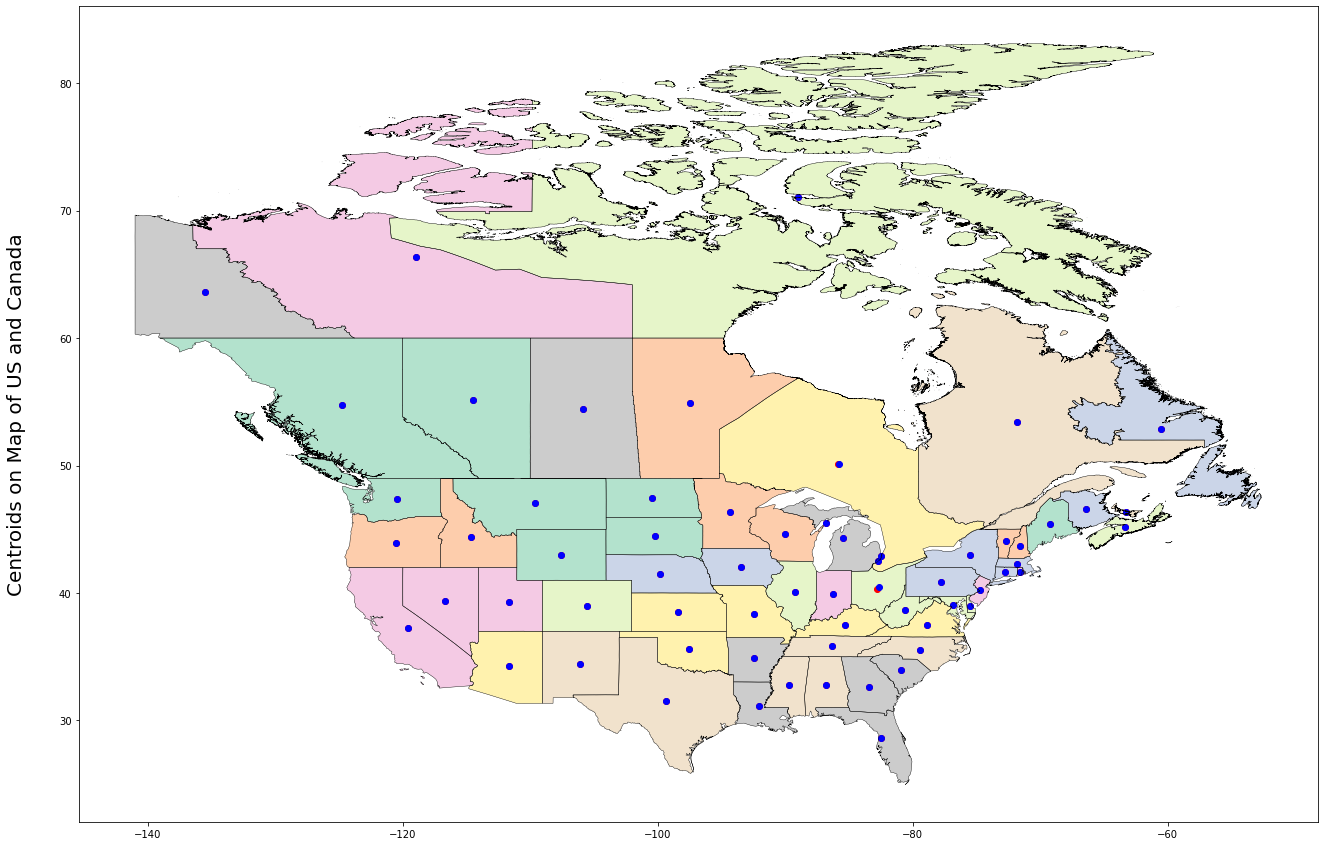

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
US.boundary.plot(ax=ax, color='Black', linewidth=.4)
US.plot(ax=ax, cmap='Pastel2', figsize=(12, 12))
CANADA.boundary.plot(ax=ax, color='Black', linewidth=.4)
CANADA.plot(ax=ax, cmap='Pastel2', figsize=(12, 12))
npe_cen.plot(ax=ax, color='red') # centroid for non planar
pe_cen.plot(ax=ax, color='blue')# centroid for planar enforced data
ax.text(-0.05, 0.5, "Centroids on Map of US and Canada", transform=ax.transAxes,
        fontsize=20, color='black', 
        ha='center', va='center', rotation='90')

In [12]:
import folium
# old centroids
m = npe_cen.explore(
     color='red',
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     name =  'Non Planar Enforced Centroids'
)
# new centroids
pe_cen.explore(
     m=m, # pass the map object
     color='blue',
     tooltip=False,
     name = 'Planar Enforced Centroids'
)

folium.LayerControl().add_to(m)  # layer control

m # execute the map

### Subset for Ohio a Polygon

In [13]:
Ohio_npe = npe[npe.STATE_NAME=="Ohio"] 

In [14]:
Ohio_pe = pe[pe.STATE_NAME=="Ohio"] 

In [15]:
Ohio_pe.geometry

27    POLYGON ((-83.618 38.678, -83.633 38.665, -83....
Name: geometry, dtype: geometry

In [16]:
Ohio_npe.geometry

27    POLYGON ((-83.273 38.609, -83.290 38.597, -83....
Name: geometry, dtype: geometry

In [17]:
Ohio_pe_centroid= Ohio_pe.centroid
Ohio_npe_centroid= Ohio_npe.centroid


<AxesSubplot:>

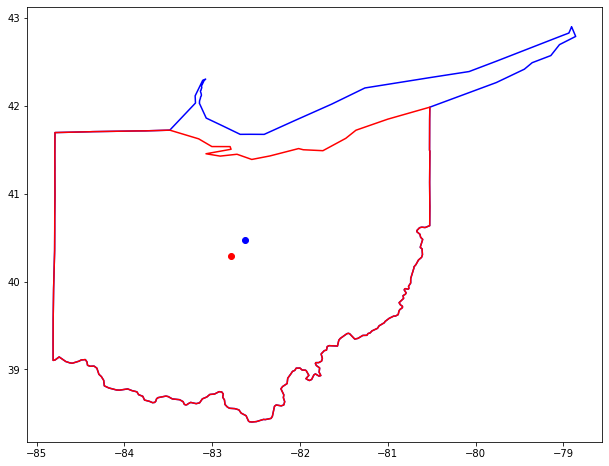

In [18]:
base =Ohio_pe.geometry.boundary.plot(edgecolor='blue', figsize=(15, 8))
Ohio_npe.geometry.boundary.plot(ax=base, color='red')
Ohio_npe_centroid.plot(ax=base, color='red')
Ohio_pe_centroid.plot(ax=base, color='blue')

The case of Ohio represent issues encountered during merging two separate data files from different sources. 
The lakes along the US and Canada border were missing from the US shapefile. Once we appended the two data sets the lakes are detected as a gaps in the data (refer to gaps notebook). `geoplanar` filled the gaps(lakes) resulting in changes to the polygon of the State of Ohio (depicted in blue color). We can anticipate this issue since this version of geoplanar does not distinguish between a geographic feature such as a water body or a data related problem.  

## Comparison of Centroids 

There can be multiple ways to compare geometries in geopandas. Here we can test four different apprroaches:

In [19]:
# geom_equals
pe['equals'] = npe_cen.geom_equals(pe_cen, align=False) 

# geom_almost_equals with 5 decimals
pe['almost_equals'] = npe_cen.geom_almost_equals(pe_cen, decimal=5)

#  geom_almost_equals with all of centroid decimals
pe['almost_equals_full'] = npe_cen.geom_almost_equals(pe_cen, decimal=14)

# geom_equals_exact with .00001 tolerance
pe['equals_exact'] = npe_cen.geom_equals_exact(pe_cen, tolerance=.00001, align=False)

In [20]:
pe.head()

,level_0,geometry,COUNTRY,index,AREA,PERIMETER,STATE_,STATE_ID,STATE_NAME,STATE_FIPS,...,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,equals,almost_equals,almost_equals_full,equals_exact
0,59,"POLYGON ((-89.400 47.987, -89.345 47.972, -89....",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,False,True,False,True
1,64,"POLYGON ((-82.929 42.363, -82.875 42.458, -82....",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,True,True,True,True
2,63,"POLYGON ((-82.461 42.906, -82.463 42.895, -82....",LAKE,NaN,NaN,NaN,NaN,NaN,None,None,...,None,None,None,None,None,None,True,True,True,True
3,0,"MULTIPOLYGON (((-122.453 48.129, -122.360 48.0...",US,0.0,20.750,34.956,1.0,1.0,Washington,53,...,None,None,None,None,None,None,False,False,False,False
4,1,"POLYGON ((-111.459 44.538, -111.482 44.536, -1...",US,1.0,45.132,34.527,2.0,2.0,Montana,30,...,None,None,None,None,None,None,False,True,False,True


### Centroids Geometries Equals 

In [21]:
pe.groupby(['equals']).size()

equals
False    50
True     14
dtype: int64

Text(-0.05, 0.5, 'Map of US and Canada Centroids Geometries Equal')

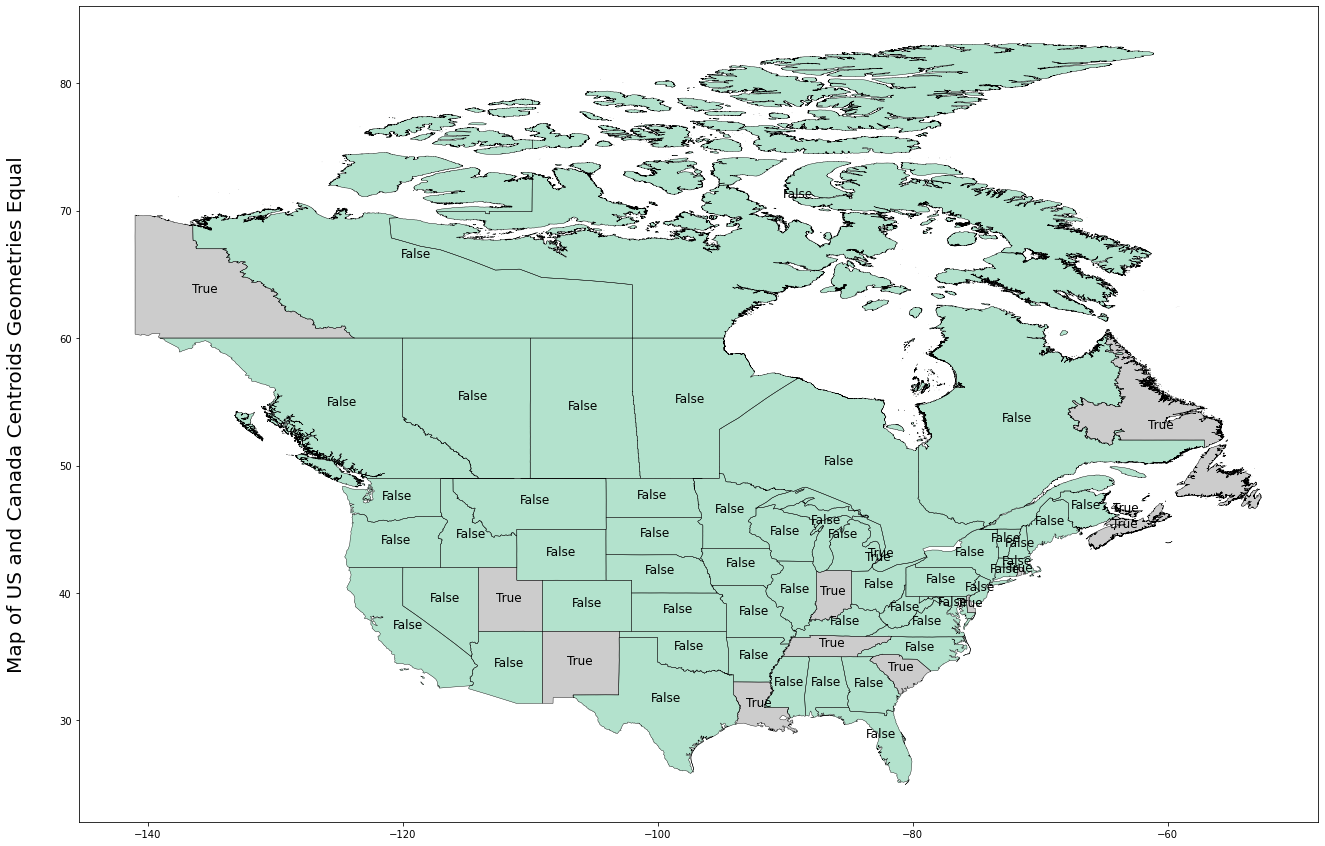

In [22]:

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
pe.apply(lambda x: ax.annotate(text=x['equals'], xy=x.geometry.centroid.coords[0],  ha='center', fontsize=12),axis=1);
pe.boundary.plot(ax=ax, color='Black', linewidth=.4)
pe.plot(ax=ax,column='equals', cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, "Map of US and Canada Centroids Geometries Equal", transform=ax.transAxes,
        fontsize=20, color='black', alpha=1,
        ha='center', va='center', rotation='90')

### Centroids Geometries Almost Equals 

In [23]:
pe.groupby(['almost_equals']).size()

almost_equals
False    13
True     51
dtype: int64

Text(-0.05, 0.5, 'Map of US and Canada Centroid Geoms Almost Equal')

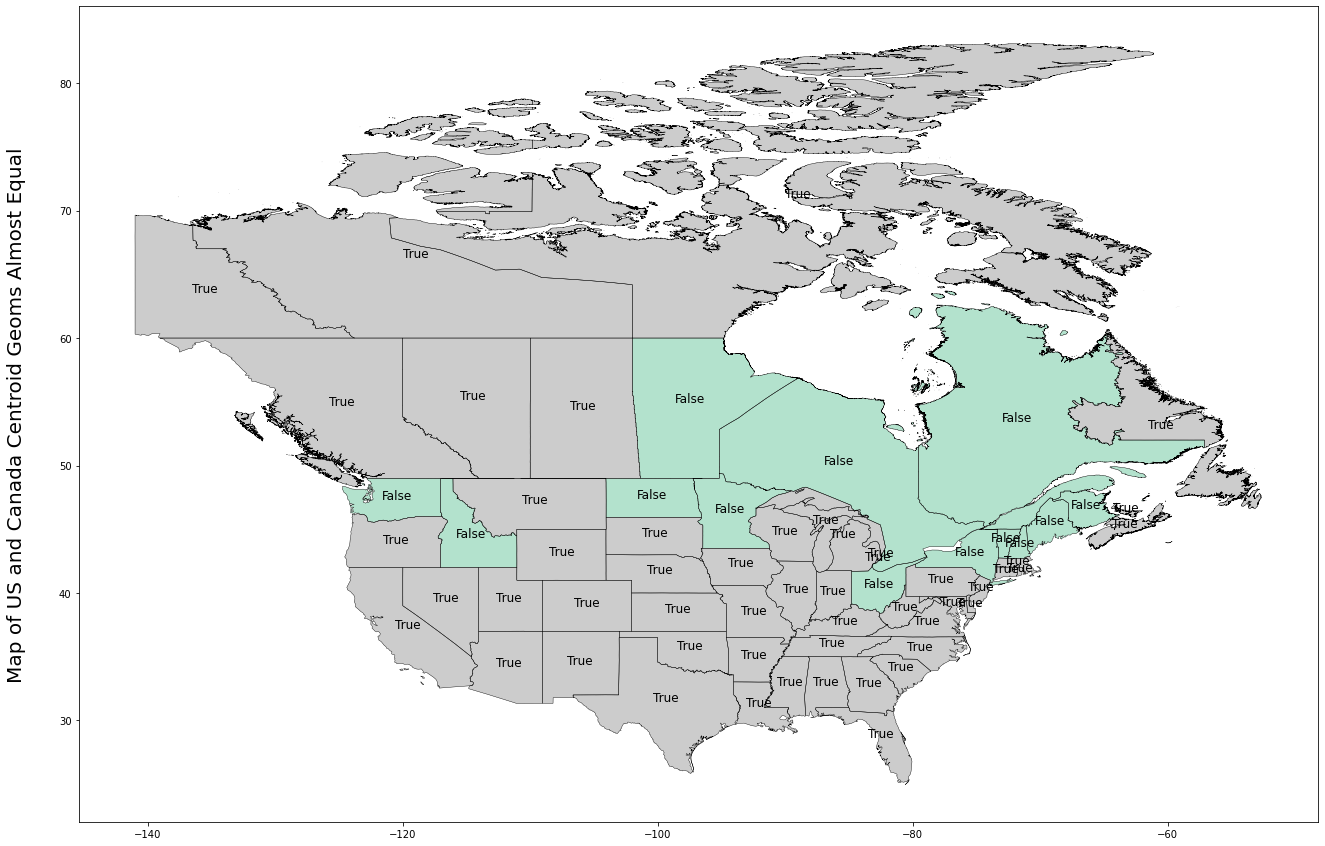

In [24]:

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
pe.apply(lambda x: ax.annotate(text=x['almost_equals'], xy=x.geometry.centroid.coords[0],  ha='center', fontsize=12),axis=1);
pe.boundary.plot(ax=ax, color='Black', linewidth=.4)
pe.plot(ax=ax,column='almost_equals', cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, "Map of US and Canada Centroid Geoms Almost Equal", transform=ax.transAxes,
        fontsize=20, color='black', alpha=1,
        ha='center', va='center', rotation='90')

### Centroids Geometries Almost Equals Full

In [25]:
pe.groupby(['almost_equals_full']).size()

almost_equals_full
False    50
True     14
dtype: int64

Text(-0.05, 0.5, 'Map of US and Canada Centroid Geoms Almost Equal Full ')

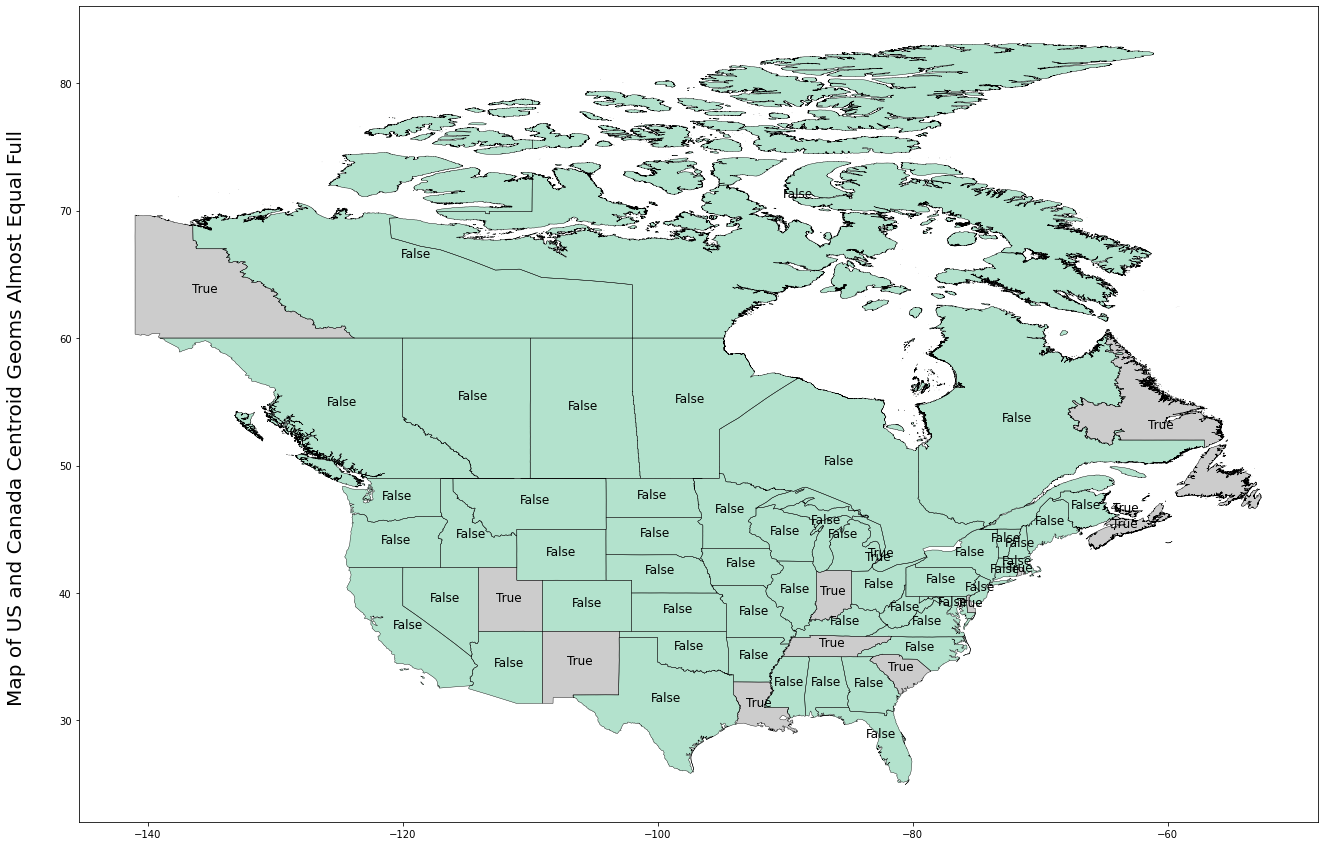

In [26]:

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
pe.apply(lambda x: ax.annotate(text=x['almost_equals_full'], xy=x.geometry.centroid.coords[0],  ha='center', fontsize=12),axis=1);
pe.boundary.plot(ax=ax, color='Black', linewidth=.4)
pe.plot(ax=ax, column='almost_equals_full', cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, "Map of US and Canada Centroid Geoms Almost Equal Full ", transform=ax.transAxes,
        fontsize=20, color='black', alpha=1,
        ha='center', va='center', rotation='90')

### Centroids Geometries Almost Exact

In [27]:
pe.groupby(['equals_exact']).size()

equals_exact
False    13
True     51
dtype: int64

Text(-0.05, 0.5, 'Map of US and Canada Centroid Geometries Equals Exact ')

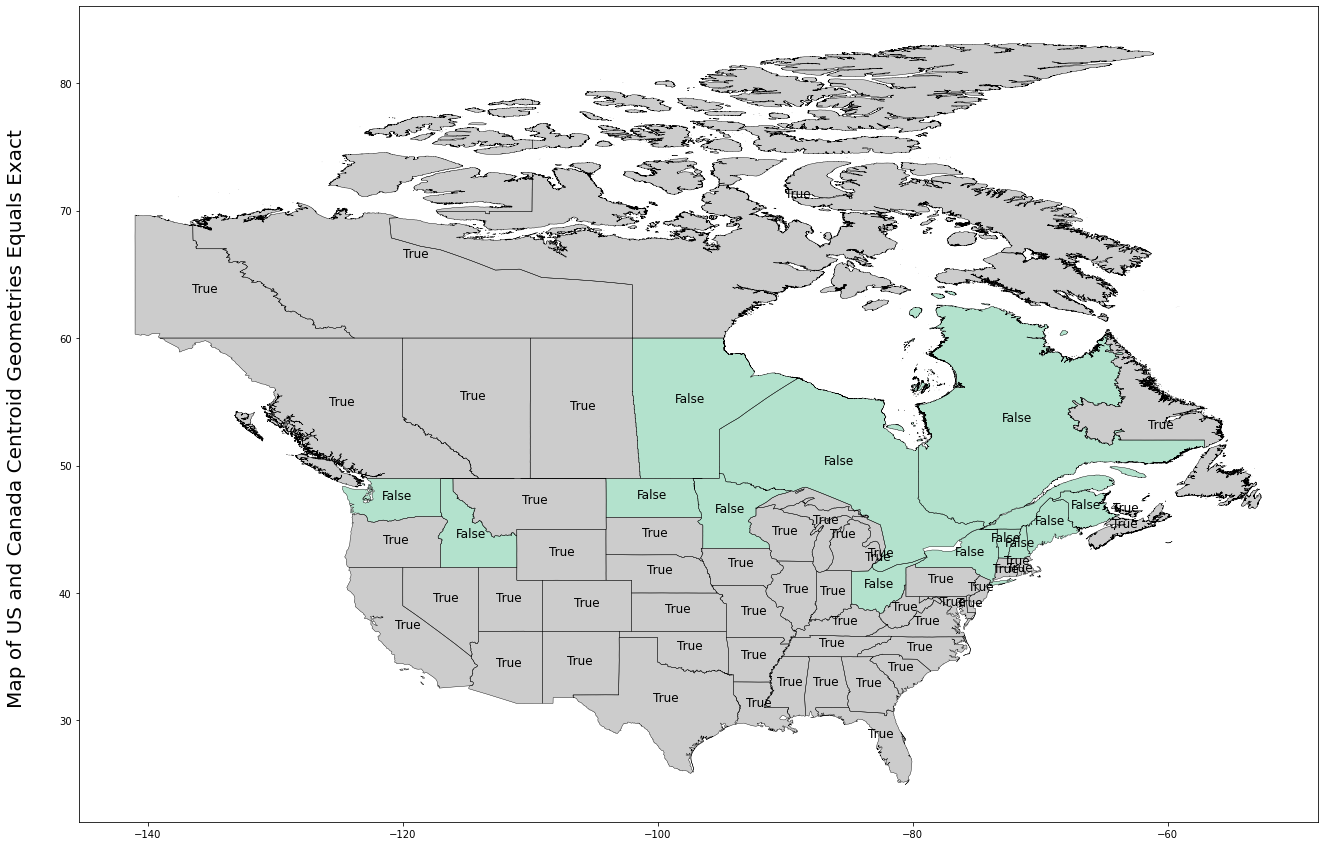

In [28]:

fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
pe.apply(lambda x: ax.annotate(text=x['equals_exact'], xy=x.geometry.centroid.coords[0],  ha='center', fontsize=12),axis=1);
pe.boundary.plot(ax=ax, color='Black', linewidth=.4)
pe.plot(ax=ax,column='equals_exact', cmap='Pastel2', figsize=(12, 12))
ax.text(-0.05, 0.5, "Map of US and Canada Centroid Geometries Equals Exact ", transform=ax.transAxes,
        fontsize=20, color='black', alpha=1,
        ha='center', va='center', rotation='90')

Based on the type of specifications we get different results. In both the cases of centroids geometries almost exact and centroids geometries almost equals, we can clearly see the changes in centriods are at the border.